In [2]:
import numpy as np
import pandas as pd
import keras
import keras_nlp
import json
import tensorflow as tf
from keras import Input, Model
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

In [3]:
preprocessor = keras_nlp.models.RobertaPreprocessor.from_preset("roberta_base_en")
backbone = keras_nlp.models.RobertaBackbone.from_preset("roberta_base_en")
backbone.trainable = False

inputs = Input(shape=(), dtype="string", name="sentence")
preprocess = preprocessor(inputs)
embed = backbone(preprocess)
encoder = Model(inputs=inputs, outputs=embed)

E0000 00:00:1746602077.500659    5746 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746602077.514371    5746 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
cnn = keras.saving.load_model(
    "roberta_cnn.keras",
    custom_objects={
        "Conv1D": keras.layers.Conv1D,
        "LeakyReLU": keras.layers.LeakyReLU,
        "CategoricalCrossentropy": losses.CategoricalCrossentropy,
        "F1Score": metrics.F1Score,
        "RMSprop": optimizers.RMSprop,
        # add any other custom layers, losses, or metrics here
    }
)
embed_cnn = cnn(embed)

full_model = Model(inputs=inputs, outputs=embed_cnn)
levels = ["Knowledge", "Comprehension", "Application", "Analysis", "Synthesis", "Evaluation"]
np.sort(levels)

array(['Analysis', 'Application', 'Comprehension', 'Evaluation',
       'Knowledge', 'Synthesis'], dtype='<U13')

In [5]:
def get_dataframe_from_json(json_file):
    with open(json_file, 'r') as f:
        dialogues = json.load(f)
    # add dialogues[1]["utterances"] to the dataframe
    utterance_df = pd.DataFrame()
    for i in range(1, len(dialogues)):
        utterance_df = pd.concat([utterance_df, pd.DataFrame(dialogues[i]["utterances"])], ignore_index=True)
    return utterance_df

In [6]:

utterance_df = get_dataframe_from_json("../dailydialog/attitude_emotion_dialogues.json")
utterance_df

,turn,utterance,emotion,act,hat
0,0,"Stop running around in front of the TV , will ...",no_emotion,question,
1,1,"I've tried , but I can't stand the bald man ta...",no_emotion,inform,
2,2,Then stay away . No one is keeping you from do...,no_emotion,inform,
3,3,Don't be so irritable . I just don't understan...,no_emotion,inform,
4,4,"All right , I will explain it to you later on ...",no_emotion,directive,
...,...,...,...,...,...
4279,4,"If you like , I'll take you to a new restauran...",happiness,directive,
4280,5,"Sure , I'd love to . I heard Sichuan cuisine i...",happiness,commissive,
4281,6,"Great , I love hot food too .",happiness,inform,
4282,7,"Well , let's finish this great dinner first .",happiness,directive,


In [12]:
utterance_df['utterance'] = utterance_df['utterance'].astype(str)

objects = []
utterance_tensor = tf.constant(utterance_df['utterance'], dtype=tf.string)
predictions = full_model.predict(utterance_tensor, batch_size=32)
bloom_indices = np.argmax(predictions, axis=1)


134/134 ━━━━━━━━━━━━━━━━━━━━ 662s 5s/step


In [27]:
utterance_df['bloom_indices'] = np.sort(levels)[bloom_indices]

In [31]:
utterance_df.to_json('utterances_with_bloom.json', orient='records', lines=True)

In [41]:
utterance_df[utterance_df['bloom_indices'] == 'Analysis']

,turn,utterance,emotion,act,hat,bloom_indices
9,0,I was just about to go to bed when the telepho...,no_emotion,inform,,Analysis
30,2,But I work hard all the time for long hours . ...,no_emotion,inform,,Analysis
31,3,"Bill , you know that work is not the same as e...",no_emotion,inform,,Analysis
33,5,How about going for a walk instead of sitting ...,no_emotion,directive,,Analysis
34,6,But I'll miss the news.It ' s important in my ...,no_emotion,commissive,,Analysis
...,...,...,...,...,...,...
4195,5,I don't like ice cream with too many different...,no_emotion,inform,,Analysis
4260,0,"Please help yourself to whatever you like , do...",happiness,directive,,Analysis
4265,5,I'll have another cup of beer insist . I know ...,happiness,commissive,,Analysis
4270,2,"I ordered my dish about a half an hour ago , b...",no_emotion,inform,,Analysis


In [32]:
for entry in utterance_df:
    if entry['emotion'] in ['anger', 'disgust', 'fear', 'sadness']:
        entry['hat'] = "red"
    if entry['emotion'] in ["no_emotion", "surprise"] and bloom_indices in ['Knowledge', 'Evaluation']:
        entry['hat'] = "white"
    if bloom_indices in ['Analysis']:
        entry['hat'] = "black"

,turn,utterance,emotion,act,hat,bloom_indices
0,0,"Stop running around in front of the TV , will ...",no_emotion,question,,Evaluation
1,1,"I've tried , but I can't stand the bald man ta...",no_emotion,inform,,Evaluation
2,2,Then stay away . No one is keeping you from do...,no_emotion,inform,,Evaluation
3,3,Don't be so irritable . I just don't understan...,no_emotion,inform,,Evaluation
4,4,"All right , I will explain it to you later on ...",no_emotion,directive,,Comprehension
...,...,...,...,...,...,...
4279,4,"If you like , I'll take you to a new restauran...",happiness,directive,,Evaluation
4280,5,"Sure , I'd love to . I heard Sichuan cuisine i...",happiness,commissive,,Evaluation
4281,6,"Great , I love hot food too .",happiness,inform,,Evaluation
4282,7,"Well , let's finish this great dinner first .",happiness,directive,,Evaluation


In [9]:
# predict bloom levels for each utterance
utterance_df['utterance'] = utterance_df['utterance'].astype(str)

objects = []
for utterance in utterance_df['utterance'][0:2]:
    print(utterance)
    utterance_tensor = tf.constant([utterance], dtype=tf.string)
    predictions = full_model.predict(utterance_tensor)
    bloom_indices = np.argmax(predictions, axis=1)
    obj = {}
    obj["utterance"] = utterance
    obj["predictions"] = predictions
    obj["bloom"] = np.sort(levels)[bloom_indices]
    objects.append(obj)

predictions_df = pd.DataFrame(objects)
predictions_df

Stop running around in front of the TV , will you ? Why don't you just sit and watch ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
I've tried , but I can't stand the bald man talking so loudly in the program .
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


,utterance,predictions,bloom
0,"Stop running around in front of the TV , will ...","[[0.02471896, 3.0796073e-06, 0.00018996448, 0....",[Evaluation]
1,"I've tried , but I can't stand the bald man ta...","[[0.14352517, 0.0005792224, 0.0003196501, 0.85...",[Evaluation]


In [1]:
predictions_df


NameError: name 'predictions_df' is not defined

In [5]:
# open labeled_from_book.csv
labeled_df = pd.read_csv('../labeled_from_book.csv', encoding='utf-8')

labeled_df

,examples,hat
0,If you want the facts and figures you can (exp...,white
1,Give me your broad white hat thinking on unemp...,white
2,Now give me the figures for school-leavers si...,white
3,"As I said, he returned to his apartment at six...",white
4,"Mr Jones, did you actually see the defendant g...",white
...,...,...
308,We seem to have got stuck in an argument. We’l...,blue
309,We are using the map mode and not the argument...,blue
310,You have both had your say. To go any further ...,blue
311,Will you please stop arguing,blue


In [12]:
predictions_labeled_df = pd.DataFrame([])
for ld in labeled_df['examples']:
    print(ld)
    utterance_tensor = tf.constant([ld], dtype=tf.string)
    predictions = full_model.predict(utterance_tensor)
    bloom_indices = np.argmax(predictions, axis=1)
    obj = {}
    obj["utterance"] = ld
    obj["predictions"] = predictions
    obj["bloom"] = np.sort(levels)[bloom_indices]
    predictions_labeled_df = pd.concat([predictions_labeled_df, pd.DataFrame([obj])], ignore_index=True)

If you want the facts and figures you can (expletive deleted) have them


2025-05-06 17:34:57.495421: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Give me your broad white hat thinking on unemployment
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
Now  give me the figures for school-leavers six months after they have left school
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
As I said, he returned to his apartment at six-thirty in the morning because he had spent the whole night gambling
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
Mr Jones, did you actually see the defendant gambling on the night of 30 June, or did he tell you he had been gambling
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
No, Your Honour. But he goes gambling almost every night
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
Mr Jones, if you were wearing the white thinking hat, what might you have said
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
I observed the defendant returning to his apartment at six-thirty in the morning on 1 July
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Thank you. You may stand down
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
Last year there was a tw

In [13]:
predictions_labeled_df

,utterance,predictions,bloom
0,If you want the facts and figures you can (exp...,"[[0.9060663, 0.004327329, 0.012907454, 0.07626...",[Analysis]
1,Give me your broad white hat thinking on unemp...,"[[3.377145e-05, 2.5847945e-05, 0.99982435, 2.5...",[Comprehension]
2,Now give me the figures for school-leavers si...,"[[9.558669e-05, 0.9997588, 7.21975e-05, 6.9867...",[Application]
3,"As I said, he returned to his apartment at six...","[[0.84570324, 0.00049284403, 0.009525197, 0.13...",[Analysis]
4,"Mr Jones, did you actually see the defendant g...","[[0.99908364, 5.8225807e-05, 2.1586613e-05, 0....",[Analysis]
...,...,...,...
308,We seem to have got stuck in an argument. We’l...,"[[0.033269268, 6.3654657e-06, 0.00010753481, 0...",[Evaluation]
309,We are using the map mode and not the argument...,"[[0.0041656904, 3.8627786e-06, 3.2229338e-05, ...",[Evaluation]
310,You have both had your say. To go any further ...,"[[3.270599e-05, 1.3261895e-07, 0.0007078424, 0...",[Evaluation]
311,Will you please stop arguing,"[[9.97172e-06, 2.0526256e-06, 7.0287686e-05, 0...",[Evaluation]


In [14]:
# extend predictions_labeled_df with labeled_df["hat"]
predictions_labeled_df["hat"] = labeled_df["hat"]
predictions_labeled_df

,utterance,predictions,bloom,hat
0,If you want the facts and figures you can (exp...,"[[0.9060663, 0.004327329, 0.012907454, 0.07626...",[Analysis],white
1,Give me your broad white hat thinking on unemp...,"[[3.377145e-05, 2.5847945e-05, 0.99982435, 2.5...",[Comprehension],white
2,Now give me the figures for school-leavers si...,"[[9.558669e-05, 0.9997588, 7.21975e-05, 6.9867...",[Application],white
3,"As I said, he returned to his apartment at six...","[[0.84570324, 0.00049284403, 0.009525197, 0.13...",[Analysis],white
4,"Mr Jones, did you actually see the defendant g...","[[0.99908364, 5.8225807e-05, 2.1586613e-05, 0....",[Analysis],white
...,...,...,...,...
308,We seem to have got stuck in an argument. We’l...,"[[0.033269268, 6.3654657e-06, 0.00010753481, 0...",[Evaluation],blue
309,We are using the map mode and not the argument...,"[[0.0041656904, 3.8627786e-06, 3.2229338e-05, ...",[Evaluation],blue
310,You have both had your say. To go any further ...,"[[3.270599e-05, 1.3261895e-07, 0.0007078424, 0...",[Evaluation],blue
311,Will you please stop arguing,"[[9.97172e-06, 2.0526256e-06, 7.0287686e-05, 0...",[Evaluation],blue


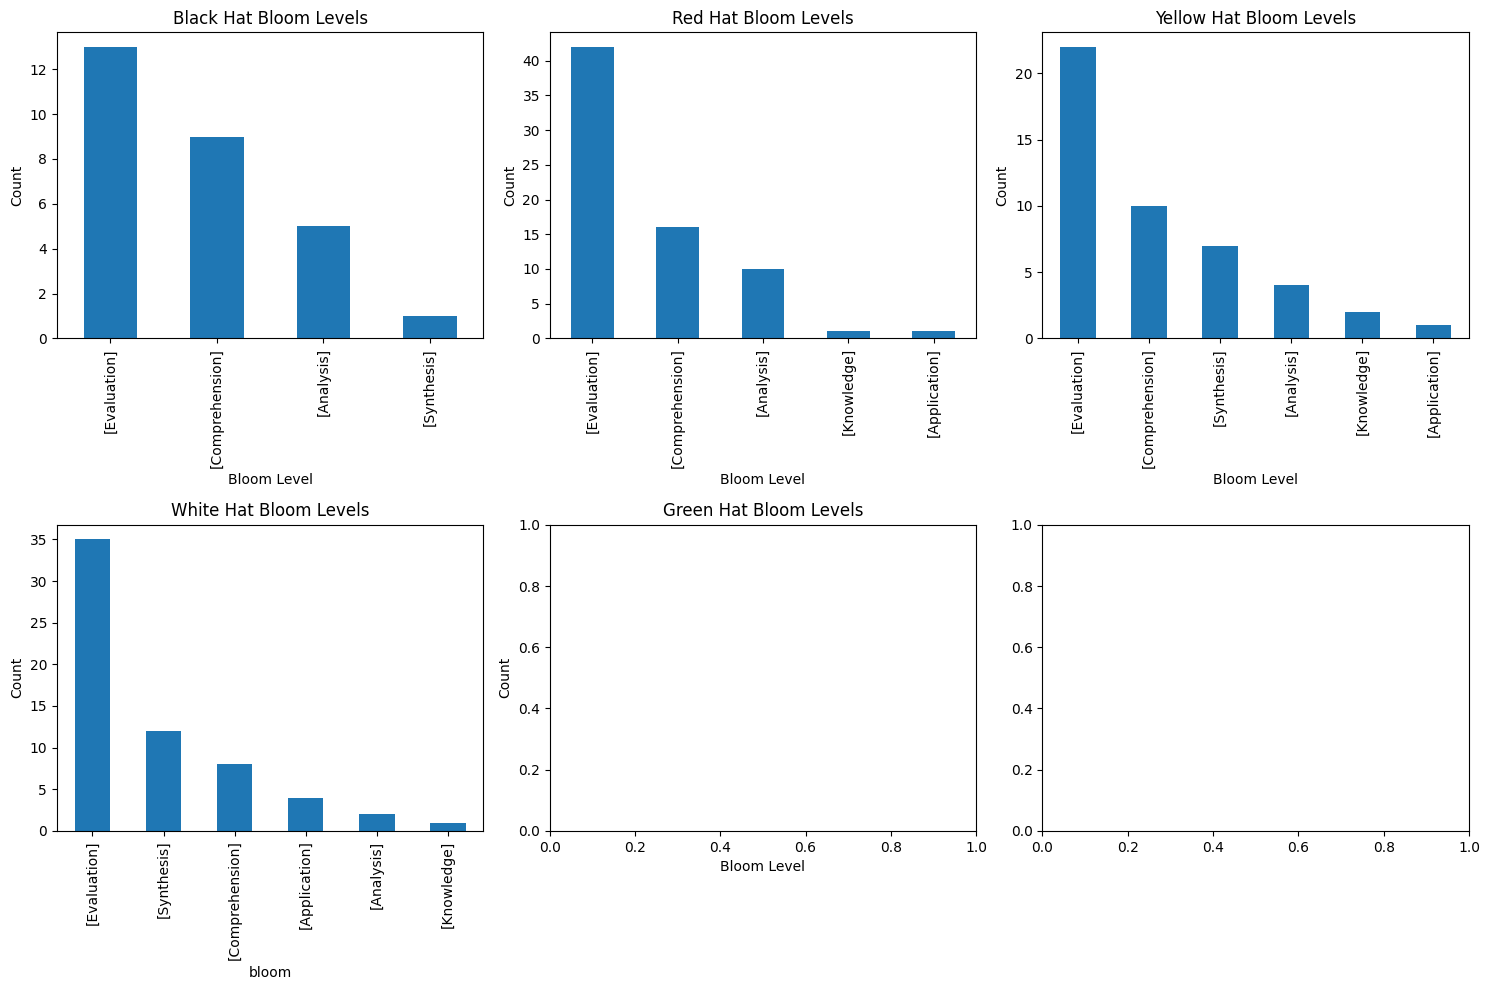

In [33]:
import matplotlib.pyplot as plt

# Create a 2x3 grid of subplots
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = ax.flatten()

# Filter dataframes
white_df = predictions_labeled_df[predictions_labeled_df["hat"] == "white"]
black_df = predictions_labeled_df[predictions_labeled_df["hat"] == "black"]
red_df = predictions_labeled_df[predictions_labeled_df["hat"] == "red"]
yellow_df = predictions_labeled_df[predictions_labeled_df["hat"] == "yellow"]
green_df = predictions_labeled_df[predictions_labeled_df["hat"] == "green"]

white_df["bloom"].value_counts().plot(kind='bar', ax=axes[3])
axes[3].set_title("White Hat Bloom Levels")
axes[3].set_xlabel("Bloom Level")
axes[3].set_ylabel("Count")


# Plot black hat bloom levels on subplot 0
black_df["bloom"].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title("Black Hat Bloom Levels")
axes[0].set_xlabel("Bloom Level")
axes[0].set_ylabel("Count")

# Plot red hat bloom levels on subplot 1
red_df["bloom"].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title("Red Hat Bloom Levels")
axes[1].set_xlabel("Bloom Level")
axes[1].set_ylabel("Count")

yellow_df["bloom"].value_counts().plot(kind='bar', ax=axes[2])
axes[2].set_title("Yellow Hat Bloom Levels")
axes[2].set_xlabel("Bloom Level")
axes[2].set_ylabel("Count")

# Plot green hat bloom levels on subplot 3
green_df["bloom"].value_counts().plot(kind='bar', ax=axes[3])
axes[4].set_title("Green Hat Bloom Levels")
axes[4].set_xlabel("Bloom Level")
axes[4].set_ylabel("Count")


# Adjust layout
plt.tight_layout()
plt.show()


